In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_boston
boston = load_boston() # データセットの読み込み

In [11]:
import numpy as np
lr = LinearRegression(fit_intercept=False)
n = 10
X = np.eye(10)[:5]
b = np.ones(10)[:5]
lr.fit(X, b)
lr.intercept_, lr.coef_

(0.0, array([1., 1., 1., 1., 1., 0., 0., 0., 0., 0.]))

In [15]:
np.concatenate([X, X[:2]])

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [14]:
X

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

<BarContainer object of 204 artists>

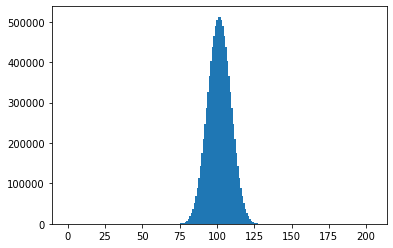

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def convolve(f, g):
    fft_len = pow(2, (len(f)+len(g)-1).bit_length())
    # フーリエ変換
    Ff = np.fft.rfft(f, fft_len)
    Fg = np.fft.rfft(g, fft_len)
    # 各点積
    Fh = Ff * Fg
    # フーリエ逆変換
    h = np.fft.irfft(Fh, fft_len)
    # 小数になっているので、整数にまるめる
    h = np.rint(h).astype(np.uint64)
    return h[:len(f) + len(g) - 1]

def convolve2(f, g, P):
    f1, f2 =np.divmod(f, 1<<15)
    g1, g2 =np.divmod(g, 1<<15)
    a = convolve(f1, g1) % P
    c = convolve(f2, g2) % P
    b = (convolve(f1+f2, g1+g2)-(a+c)) % P
    return ((a<<30)+(b<<15)+c)%P

n, m = 10, 10
f = np.array([0]*n+[1]*m+[0]*n)
g = f
for i in range(6):
    g = convolve(f, g)

plt.bar(np.arange(len(g)), g, width=1.0)

In [44]:
def matmul1(A, B):
    assert len(A[0])==len(B)
    n, m, l = len(A), len(B[0]), len(B)
    return [[sum([A[i][k]*B[k][j] for k in range(l)]) for j in range(m)] for i in range(n)]

def matmul2(A, b):
    assert len(A[0])==len(b)
    n, l = len(A), len(b)
    return [sum([A[i][j]*b[j] for j in range(l)]) for i in range(n)]

def matmul3(a, B):
    assert len(a)==len(B)
    l, m = len(a), len(B[0])
    return [sum([a[j]*B[j][i] for j in range(l)]) for i in range(m)]

def matmul_scalar(a, X):
    if hasattr(X[0], "__iter__"):
        return [[a*X[i][j] for j in range(len(X[0]))] for i in range(len(X))]
    elif hasattr(X, "__iter__"):
        return [a*X[i] for i in range(len(X))]
    else:
        return a*X

def matmul(A, B):
    if not hasattr(A, "__iter__"):
        return matmul_scalar(A, B)
    elif hasattr(A[0], "__iter__") and hasattr(B[0], "__iter__"):
        return matmul1(A, B)
    elif hasattr(A[0], "__iter__"):
        return matmul2(A, B)
    else:
        return matmul3(A, B)

def T(A):
    if hasattr(A[0], "__iter__"):
        return [[A[j][i] for j in range(len(A))] for i in range(len(A[0]))]
    else:
        return [[A[i]] for i in range(len(A))]

def matadd(A, B):
    if hasattr(A[0], "__iter__"):
        return [[A[i][j]+B[i][j] for j in range(len(B[0]))] for i in range(len(B))]
    elif hasattr(B, "__iter__"):
        return [A[i]+B[i] for i in range(len(B))]
    else:
        return A+B

def matsub(A, B):
    if hasattr(A[0], "__iter__"):
        return [[A[i][j]-B[i][j] for j in range(len(B[0]))] for i in range(len(B))]
    elif hasattr(B, "__iter__"):
        return [A[i]-B[i] for i in range(len(B))]
    else:
        return A-B

def matinv(X):
    assert len(X)==len(X[0])
    n = len(X)
    X = [[X[i][j] for j in range(n)] for i in range(n)]
    ret = [[0]*n for _ in range(n)]
    for i in range(n):
        ret[i][i] = 1
    for i in range(n):
        p = i
        while X[p][i] == 0:
            p += 1
        if p !=  i:
            ret[i], ret[p] = ret[p], ret[i]
            X[i], X[p] = X[p], X[i]
        ret[i] = matmul(1/X[i][i], ret[i])
        X[i] = matmul(1/X[i][i], X[i])
        for j in range(n):
            if j==i:
                continue
            if X[j][i]!=0:
                ret[j] = matsub(ret[j], matmul(X[j][i], ret[i]))
                X[j] = matsub(X[j], matmul(X[j][i], X[i]))
    return ret

def matinv_tmp(X, eps=1e-10):
    assert len(X)==len(X[0])
    n = len(X)
    for i in range(100):
        try:
            return matinv(X)
        except Exception as e:
            X = [[X[i][j]+eps*(i==j) for j in range(n)] for i in range(n)]
    raise ValueError


A = [[1, 1, 1], [0, 2, 2], [0, 3, 3]]
print(matmul(matinv_tmp(A), A))
n = len(A)
eps = 1e-10
X = [[A[i][j]+eps*(i==j) for j in range(n)] for i in range(n)]
print(matmul(matinv_tmp(A), X))

[[0.9999999999, 2.000000165480742e-11, 2.000000165480742e-11], [0.0, 0.3999977111816406, 0.3999977111816406], [0.0, 0.6000003814697266, 0.6000003814697266]]
[[1.0, 0.0, 0.0], [0.0, 0.9999980926513672, -1.9073486328125e-06], [0.0, 0.0, 1.0]]
